# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [1]:
# Import essential libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [2]:
# Importing the file porter_data_1.csv and review data
df = pd.read_csv('porter_data_1.csv')
df.head()

market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  
0                14.0                      21.0     34.44  
1                 2.0                       2.0     27.60  
2                 6.0                      18.0     11.56  
3                 6.0                       8.0     31.80  
4                 5.0                       7.0      8.20

## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [3]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])
# checking if the change works well
print(df[['created_at', 'actual_delivery_time']].dtypes)

created_at              datetime64[ns]
actual_delivery_time    datetime64[ns]
dtype: object


##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [4]:
# Convert categorical features to category type
# Convert 'store_primary_category' to category type
df['store_primary_category'] = df['store_primary_category'].astype('category')

# checking if the change works well
print(df['store_primary_category'].dtypes)

category


#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [5]:
# Calculate time taken in minutes
df['delivery_duration_min'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

##### **2.2.2** <font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [6]:
# Extract the hour and day of week from the 'created_at' timestamp
df['order_hour'] = df['created_at'].dt.hour
df['order_dayofweek'] = df['created_at'].dt.dayofweek  # Monday=0, Sunday=6

# Map day of week numbers to actual weekday names
day_mapping = {
    0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
    4: 'Friday', 5: 'Saturday', 6: 'Sunday'
}
df['order_day'] = df['order_dayofweek'].map(day_mapping)
# Create a categorical feature 'isWeekend'
df['isWeekend'] = df['order_dayofweek'].isin([5, 6])

# Display result
df[['delivery_duration_min', 'order_hour', 'order_day','isWeekend']].head()

delivery_duration_min  order_hour order_day  isWeekend
0                   47.0          22    Friday      False
1                   44.0          21   Tuesday      False
2                   55.0           0    Monday      False
3                   59.0           3  Thursday      False
4                   46.0           2   Tuesday      False

In [7]:
# Drop unnecessary `isWeekend` columns because it is no longer needed since we have the column for day of the week
df.drop(columns='isWeekend', inplace=True)

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [31]:
# Define target variable (y) and features (X)
# Define the target variable 'y' as a binary outcome: e.g., fast vs. slow delivery
# For illustration, consider delivery_duration_min <= 45 minutes as 'fast' (label 0), else 'slow' (label 1)
df['delivery_speed'] = (df['delivery_duration_min'] > 45).astype(int)

# Define features (exclude the original delivery duration and new target)
feature_columns = df.columns.difference(['delivery_duration_min', 'delivery_speed'])

# Define X and y
X = df[feature_columns]
y = df['delivery_speed']

# Display the shapes of X and y
X.shape, y.shape

((175777, 17), (175777,))

##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [32]:
# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Display the resulting splits
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((140621, 17), (35156, 17), (140621,), (35156,))

## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [33]:
# Define numerical and categorical columns for easy EDA and data manipulation
# Identify categorical columns (excluding the target)
categorical_columns = X.select_dtypes(include=['category', 'object', 'bool']).columns.tolist()

# Identify numerical columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Print the lists
categorical_columns, numerical_columns

(['order_day', 'store_primary_category'],
 ['distance',
  'market_id',
  'max_item_price',
  'min_item_price',
  'num_distinct_items',
  'order_protocol',
  'subtotal',
  'total_busy_dashers',
  'total_items',
  'total_onshift_dashers',
  'total_outstanding_orders'])

##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

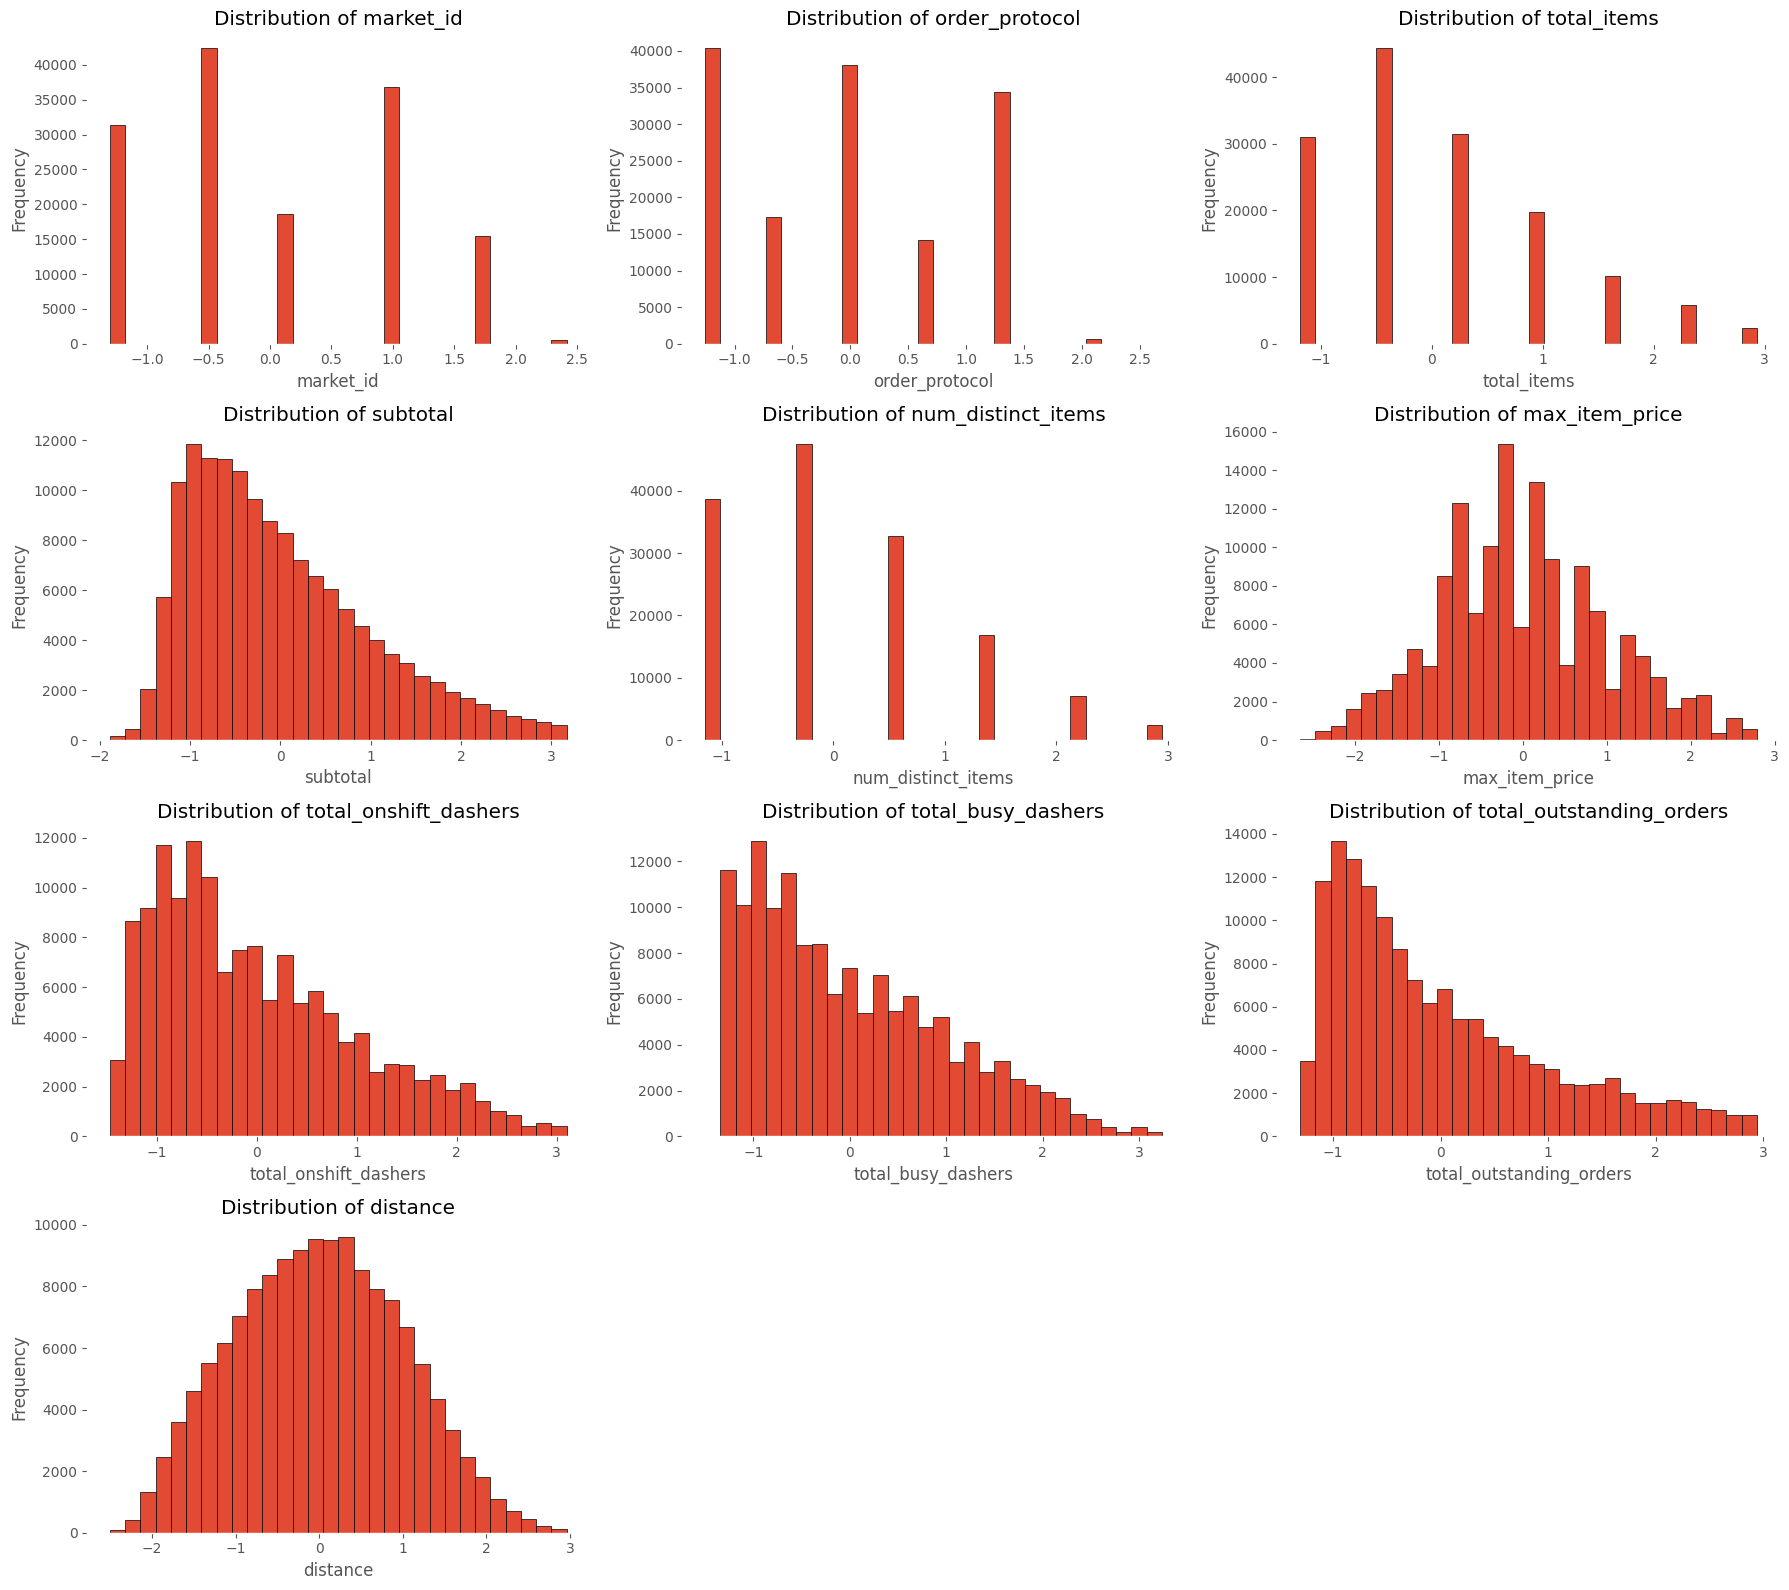

In [26]:
# Plot distributions for all numerical columns
# Set the plot style and size
plt.style.use('ggplot')
num_cols = len(numerical_columns)
num_rows = (num_cols + 2) // 3

# Create subplots for each numerical feature
fig, axes = plt.subplots(num_rows, 3, figsize=(18, num_rows * 4))
axes = axes.flatten()

# Plot each numerical column
for idx, col in enumerate(numerical_columns):
    axes[idx].set_facecolor('white')
    axes[idx].hist(X[col], bins=30, edgecolor='black')
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')

# Hide unused subplots if any
for i in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

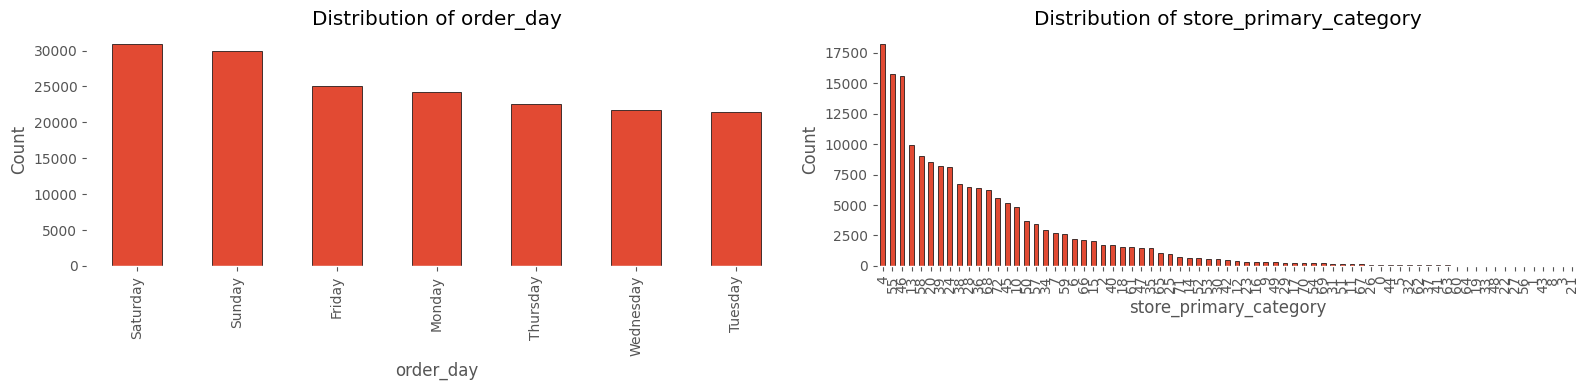

In [34]:
# Distribution of categorical columns
# Set up the plot grid
num_cat = len(categorical_columns)
num_rows = (num_cat + 1) // 2

fig, axes = plt.subplots(num_rows, 2, figsize=(16, num_rows * 4))
axes = axes.flatten()

# Plot bar charts for each categorical column
for idx, col in enumerate(categorical_columns):
    axes[idx].set_facecolor('white')
    X[col].value_counts().plot(kind='bar', ax=axes[idx], edgecolor='black')
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Count')

# Hide unused subplots if any
for i in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

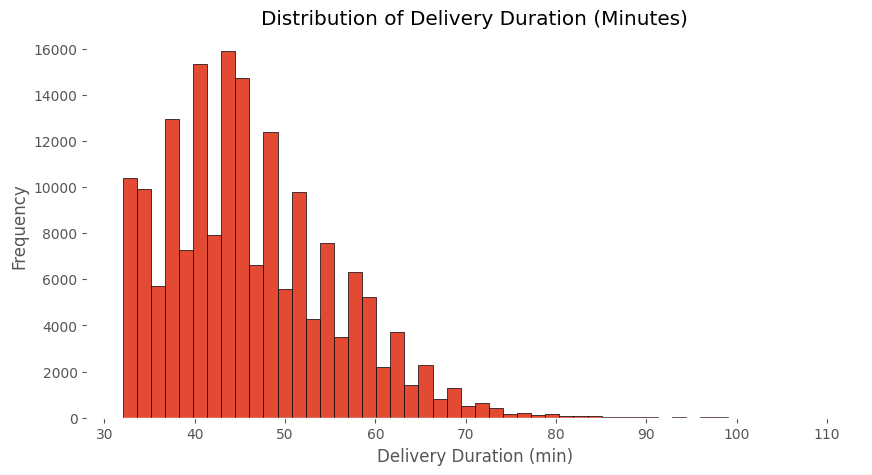

In [22]:
# Distribution of time_taken
plt.figure(figsize=(10, 5), facecolor='white')
ax = plt.gca()
ax.set_facecolor('white')
plt.hist(df['delivery_duration_min'], bins=50, edgecolor='black')
plt.title('Distribution of Delivery Duration (Minutes)')
plt.xlabel('Delivery Duration (min)')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

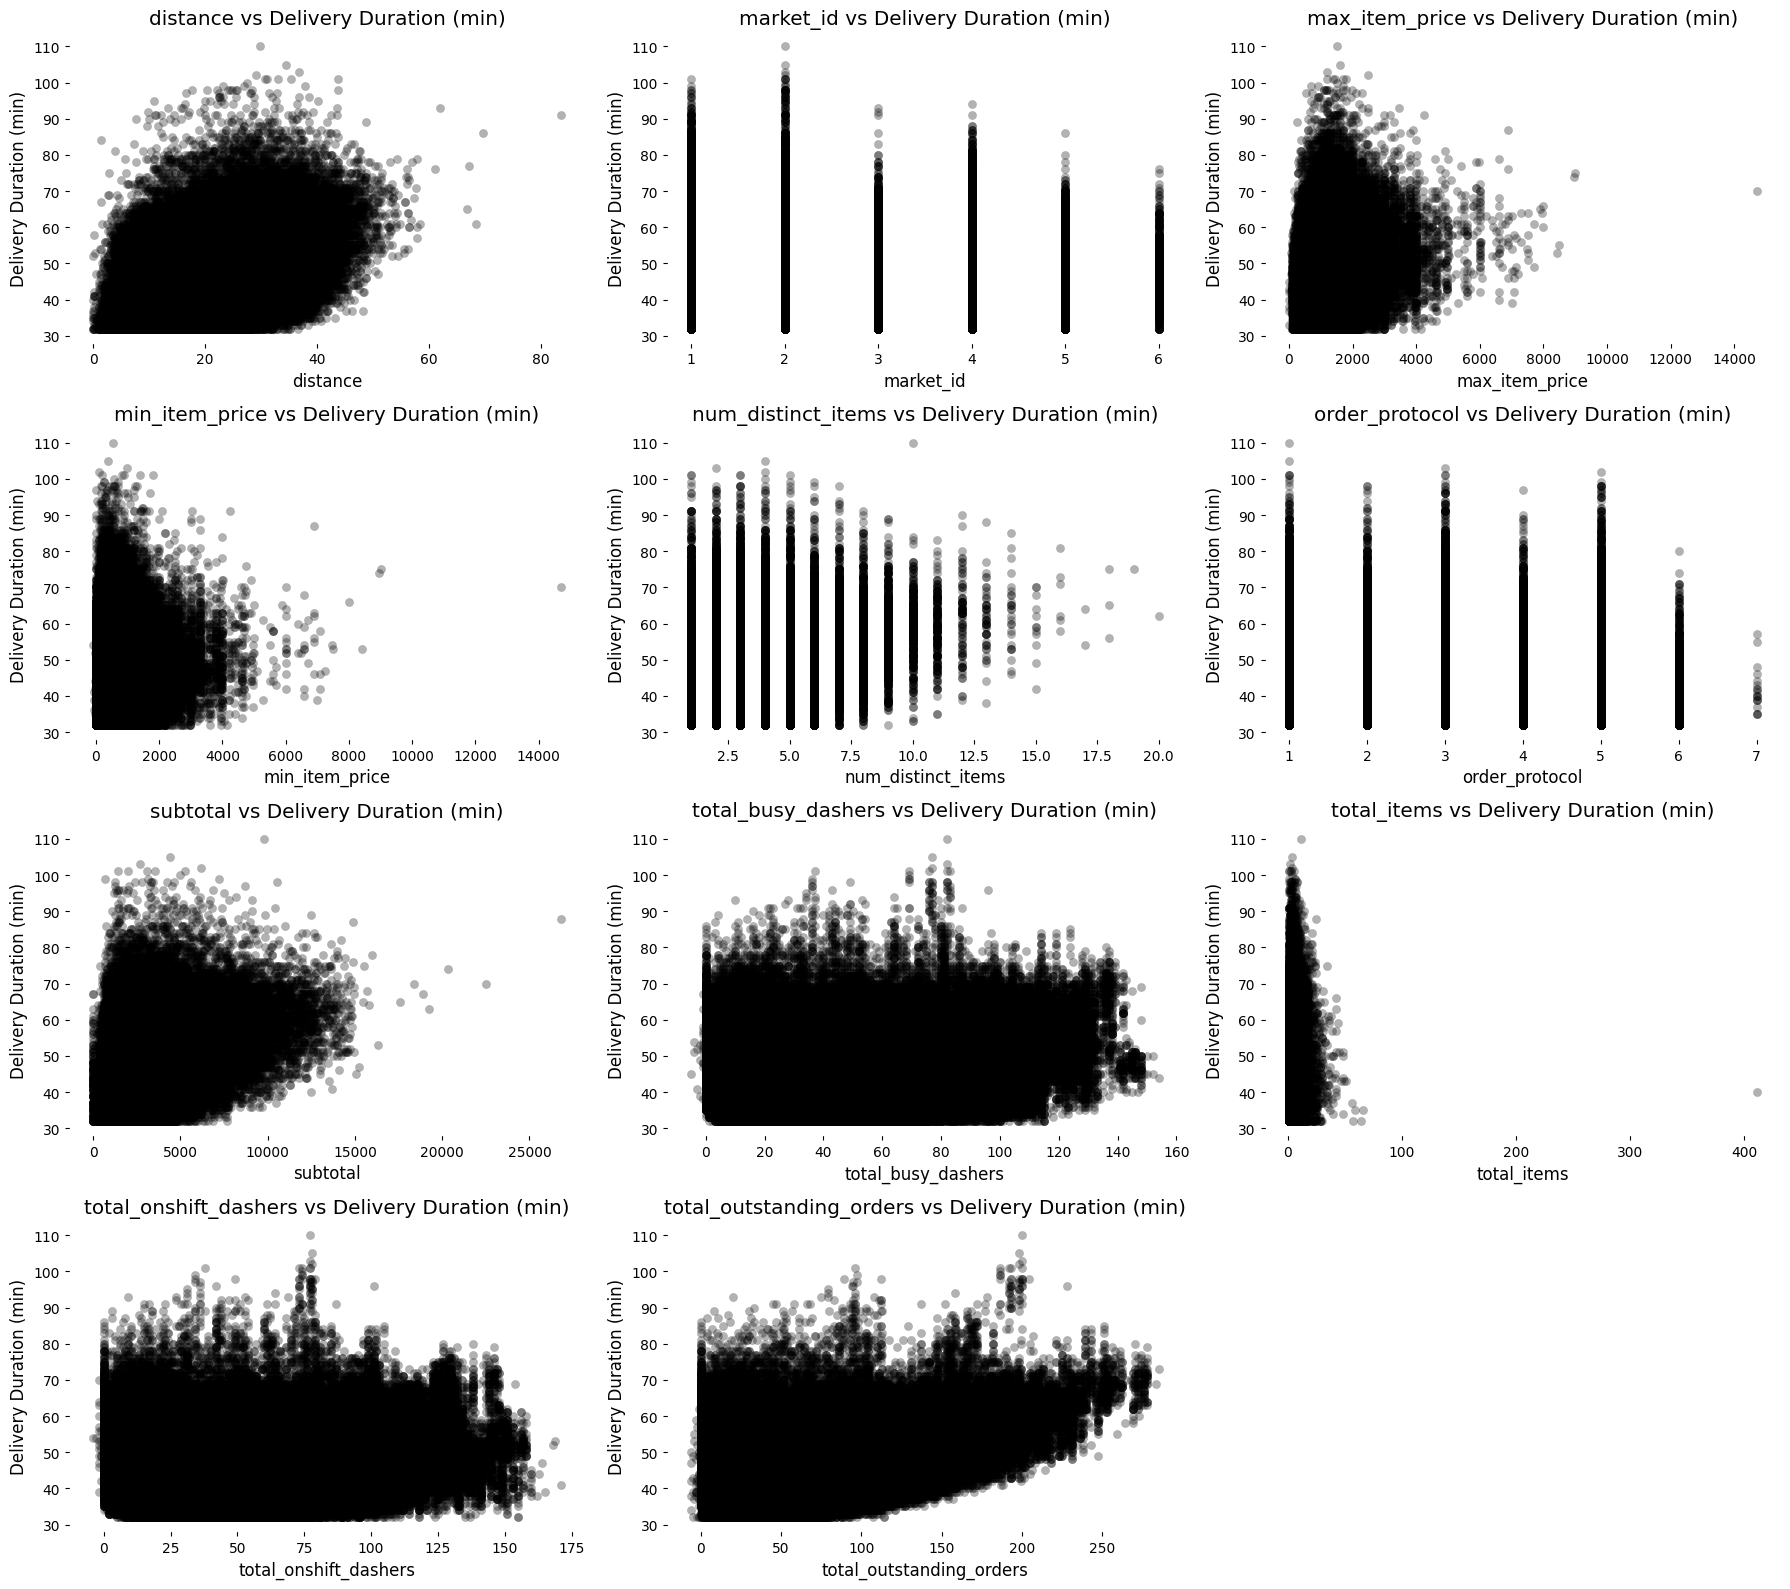

In [28]:
# Scatter plot to visualise the relationship between time_taken and other features
other_features = [col for col in numerical_columns if col != 'delivery_duration_min']

row_numbers = (len(other_features) + 2) // 3
fig, axes = plt.subplots(row_numbers, 3, figsize=(18, row_numbers * 4), facecolor='white')
axes = axes.flatten()

for idx, col in enumerate(other_features):
    axes[idx].set_facecolor('white')
    axes[idx].scatter(df[col], df['delivery_duration_min'], color='black', alpha=0.3, linewidth=0.2)
    axes[idx].set_title(f'{col} vs Delivery Duration (min)', color='black')
    axes[idx].set_xlabel(col, color='black')
    axes[idx].set_ylabel('Delivery Duration (min)', color='black')
    axes[idx].tick_params(colors='black')
    axes[idx].grid(False)

for i in range(len(other_features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

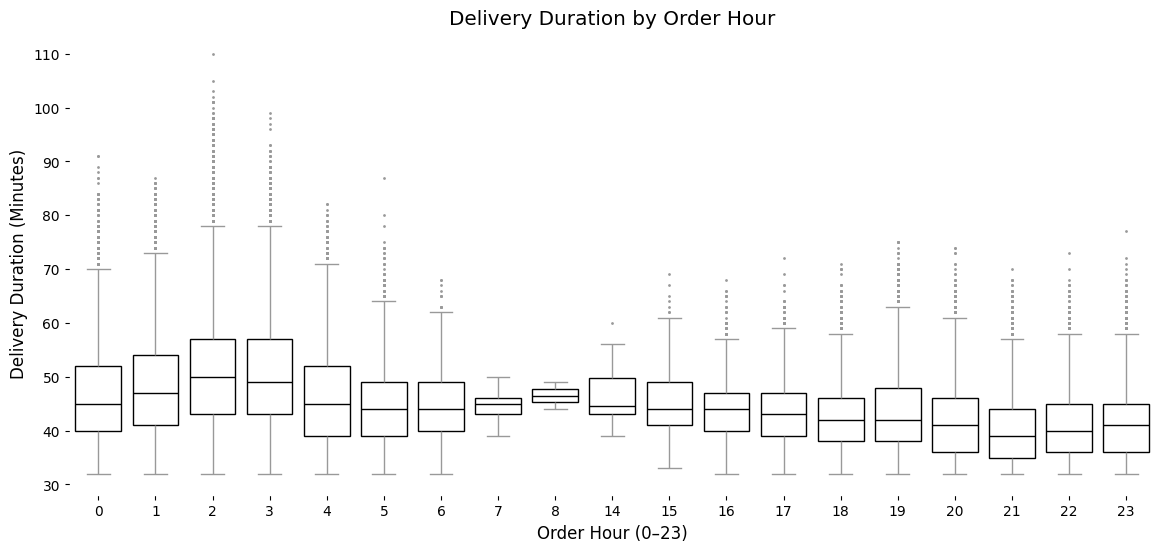

In [29]:
# Show the distribution of time_taken for different hours
plt.figure(figsize=(14, 6), facecolor='white')
ax = plt.gca()
ax.set_facecolor('white')
sns.boxplot(
    x='order_hour',
    y='delivery_duration_min',
    data=df,
    color='white',
    fliersize=1,
    linewidth=1,
    boxprops=dict(edgecolor='black'),
    medianprops=dict(color='black')
)

plt.title('Delivery Duration by Order Hour', color='black')
plt.xlabel('Order Hour (0–23)', color='black')
plt.ylabel('Delivery Duration (Minutes)', color='black')
ax.tick_params(colors='black')
plt.grid(False)
plt.show()

#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

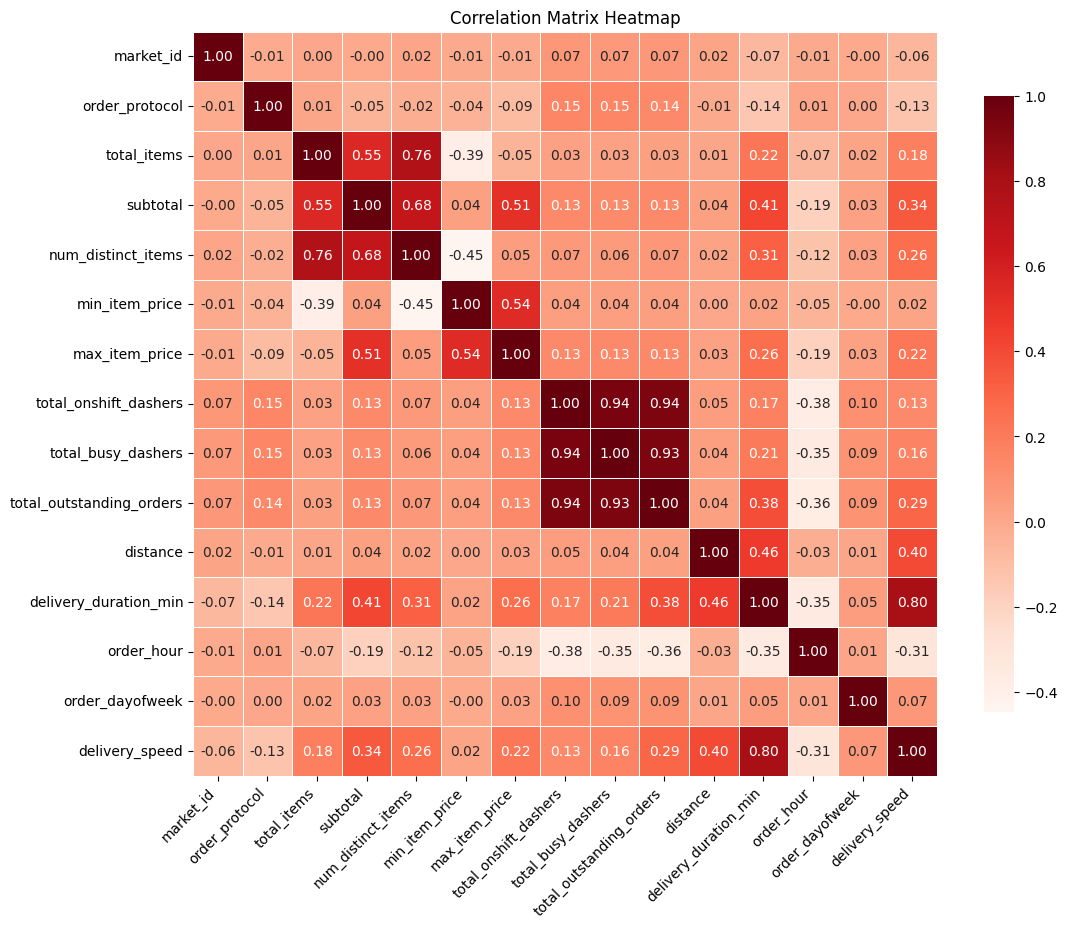

In [12]:
# Plot the heatmap of the correlation matrix
# Compute correlation matrix for numerical columns including the target
corr_matrix = df.corr(numeric_only=True)

# Plot the heatmap
plt.figure(figsize=(12, 10))
ax = sns.heatmap(
    corr_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap='Reds', 
    linewidths=0.5, 
    linecolor='white', 
    square=True, 
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Matrix Heatmap', color='black')
plt.xticks(color='black', rotation=45, ha='right')
plt.yticks(color='black', rotation=0)
plt.show()

##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [34]:
# Drop 3-5 weakly correlated columns from training dataset
# Identify features with weak correlation
target_corr = corr_matrix['delivery_duration_min'].drop('delivery_duration_min')
weak_corr_features = target_corr[abs(target_corr) < 0.05].index.tolist()

# Limit to top 3–5 weakest for dropping
drops = weak_corr_features[:5]

# Drop these columns from the full dataset (X-related columns)
df_drops = df.drop(columns=drops)

# Show dropped features and resulting columns
drops, df_drops.columns.tolist()

(['min_item_price', 'order_dayofweek'],
 ['market_id',
  'created_at',
  'actual_delivery_time',
  'store_primary_category',
  'order_protocol',
  'total_items',
  'subtotal',
  'num_distinct_items',
  'max_item_price',
  'total_onshift_dashers',
  'total_busy_dashers',
  'total_outstanding_orders',
  'distance',
  'delivery_duration_min',
  'order_hour',
  'order_day',
  'isWeekend',
  'delivery_speed'])

#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

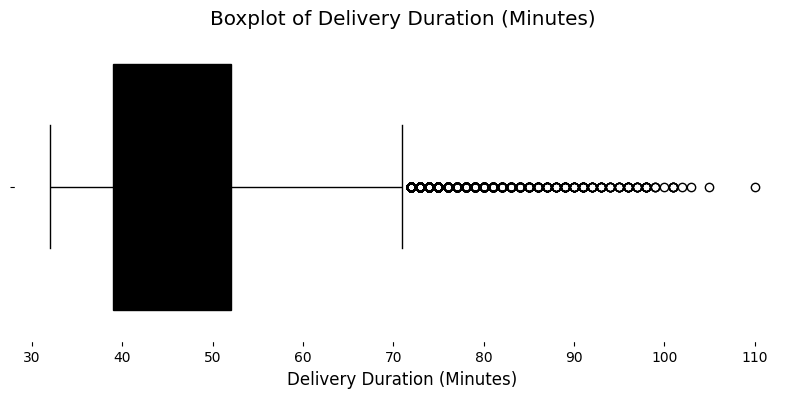

In [36]:
# Boxplot for time_taken
plt.figure(figsize=(10, 4), facecolor='white')
ax = plt.gca()
ax.set_facecolor('white')

sns.boxplot(x=df['delivery_duration_min'], color='black', boxprops=dict(edgecolor='black'), medianprops=dict(color='black'))

plt.title('Boxplot of Delivery Duration (Minutes)', color='black')
plt.xlabel('Delivery Duration (Minutes)', color='black')
ax.tick_params(colors='black')
plt.grid(False)
plt.show()

##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [14]:
# Handle outliers
#using IQR method
def remove_outliers(dataframe, columns):
    df_clean = dataframe.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# Apply the IQR outlier removal to all numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
df_no_outliers = remove_outliers(df, numerical_columns)

# Show shape before and after outlier removal
df.shape, df_no_outliers.shape

((175777, 19), (144987, 19))

## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [15]:
# Define numerical and categorical columns for easy EDA and data manipulation
# Redefine numerical and categorical columns after outlier removal
categorical_columns_cleaned = df_no_outliers.select_dtypes(include=['category', 'object', 'bool']).columns.tolist()
numerical_columns_cleaned = df_no_outliers.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Display the updated lists
categorical_columns_cleaned, numerical_columns_cleaned

(['store_primary_category', 'order_day'],
 ['market_id',
  'order_protocol',
  'total_items',
  'subtotal',
  'num_distinct_items',
  'min_item_price',
  'max_item_price',
  'total_onshift_dashers',
  'total_busy_dashers',
  'total_outstanding_orders',
  'distance',
  'delivery_duration_min'])

#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

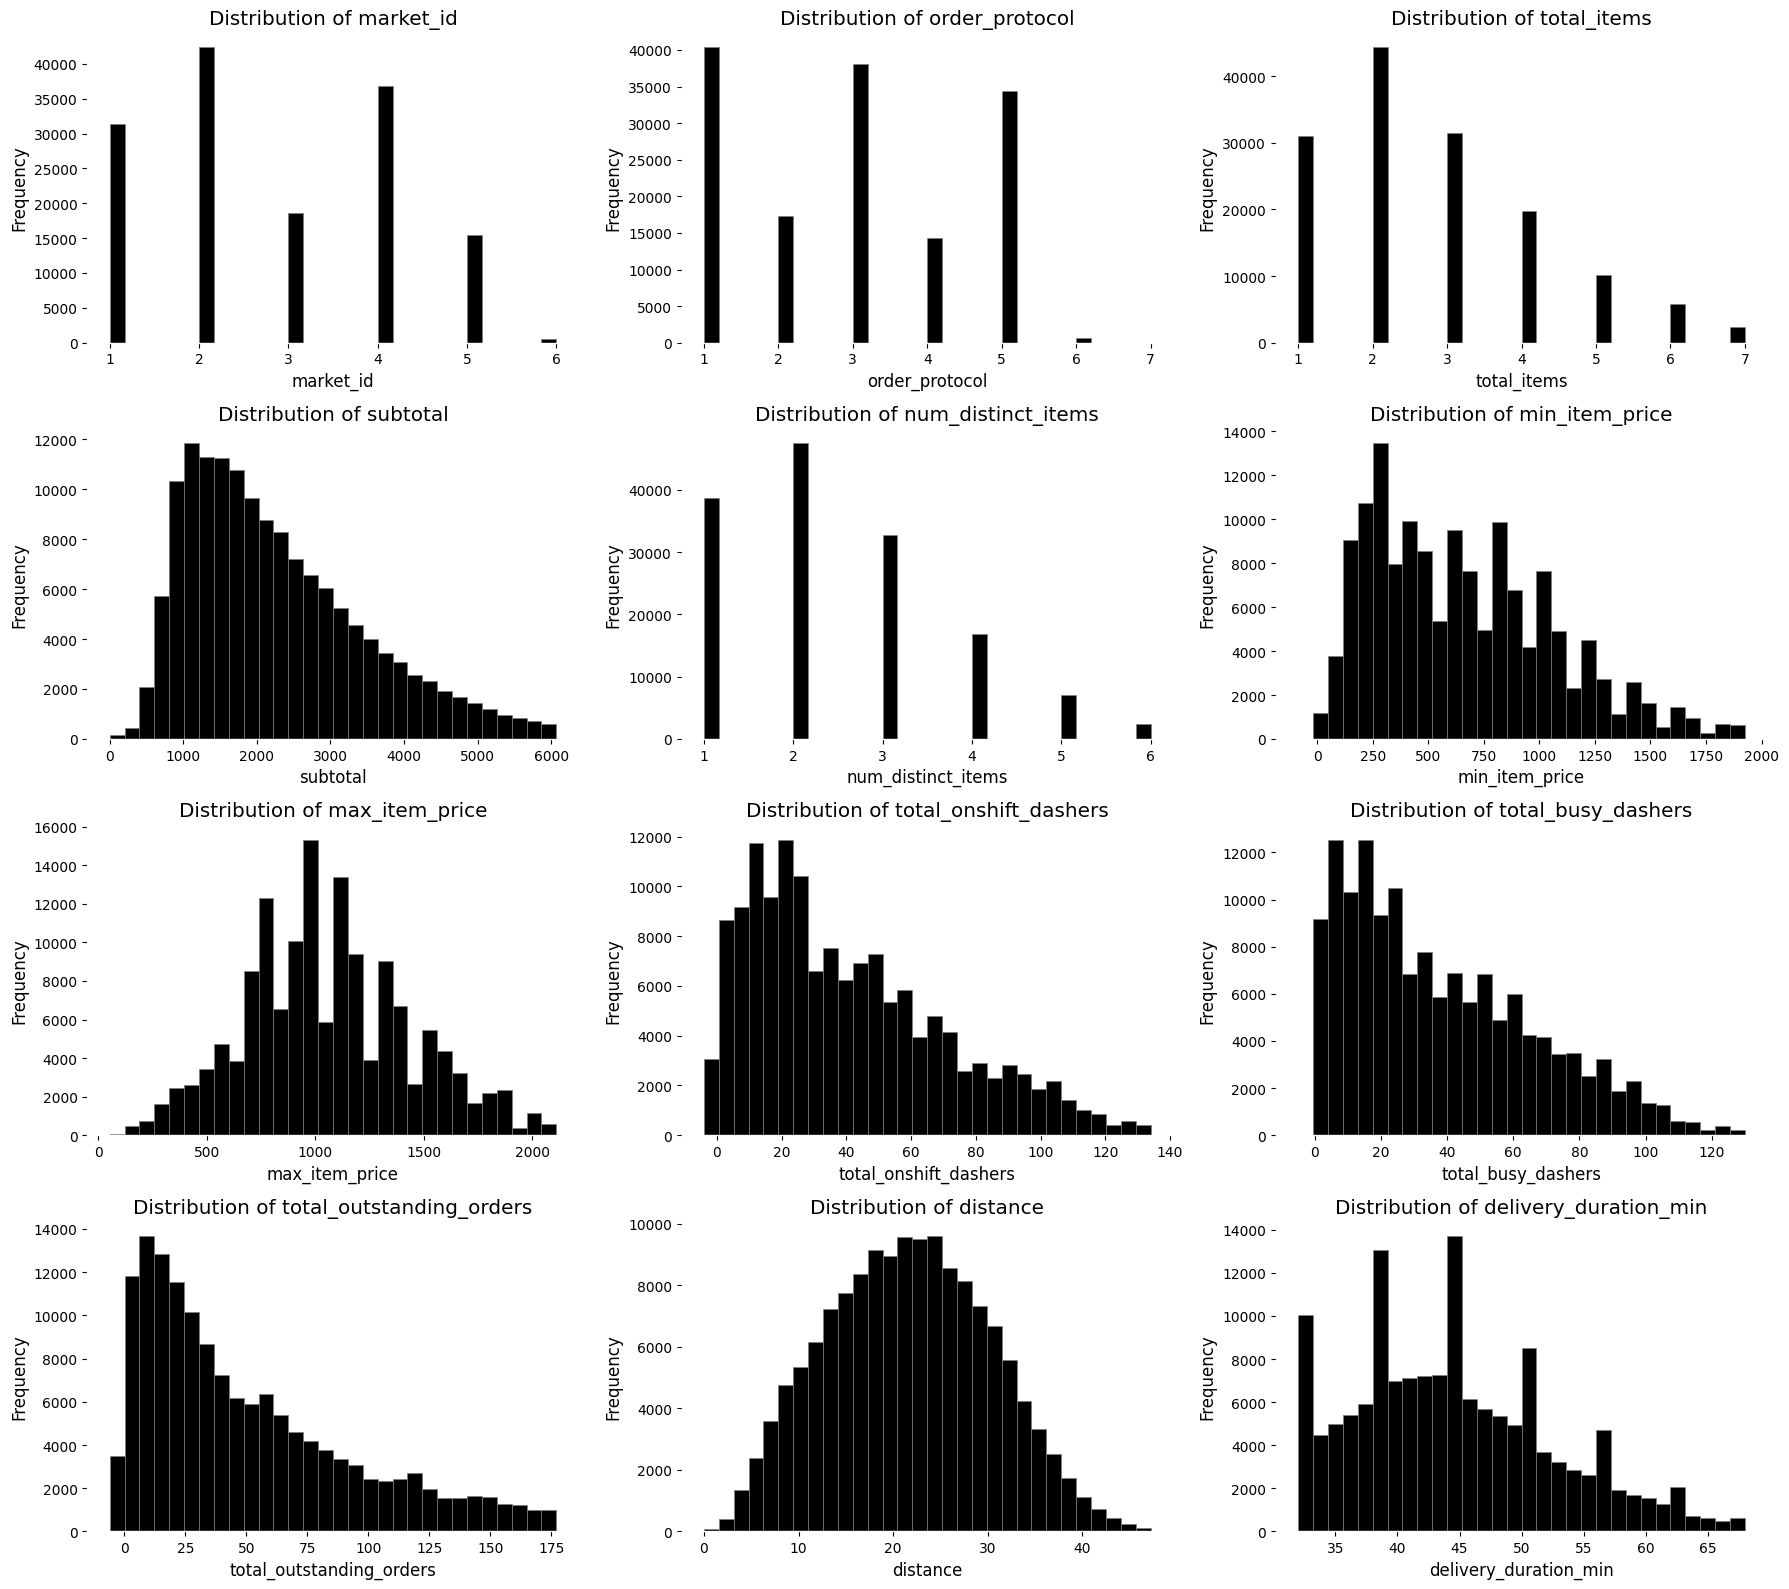

In [43]:
# Plot distributions for all numerical columns
num_cols = len(numerical_columns_cleaned)
num_rows = (num_cols + 2) // 3

fig, axes = plt.subplots(num_rows, 3, figsize=(18, num_rows * 4), facecolor='white')
axes = axes.flatten()

# Plot histograms for each numerical column
for idx, col in enumerate(numerical_columns_cleaned):
    axes[idx].set_facecolor('white')
    axes[idx].hist(df_no_outliers[col], bins=30, color='black', edgecolor='gray')
    axes[idx].set_title(f'Distribution of {col}', color='black')
    axes[idx].set_xlabel(col, color='black')
    axes[idx].set_ylabel('Frequency', color='black')
    axes[idx].tick_params(colors='black')
    axes[idx].grid(False)

# Remove extra subplots
for i in range(len(numerical_columns_cleaned), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

##### **4.1.2**
Check the distribution of categorical features

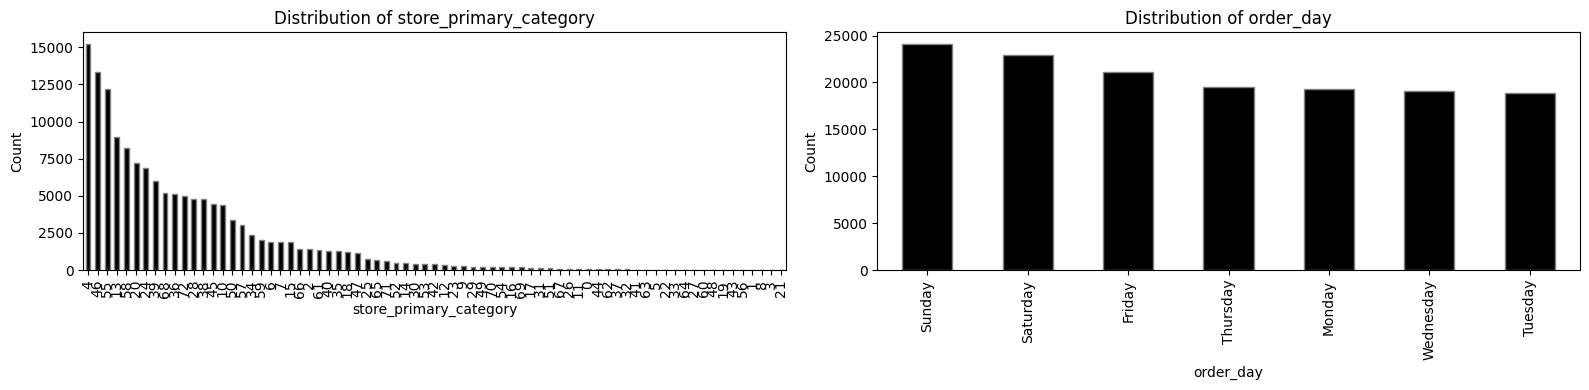

In [16]:
# Distribution of categorical columns
num_cat = len(categorical_columns_cleaned)
num_rows = (num_cat + 1) // 2

fig, axes = plt.subplots(num_rows, 2, figsize=(16, num_rows * 4), facecolor='white')
axes = axes.flatten()

# Plot bar charts for each categorical column
for idx, col in enumerate(categorical_columns_cleaned):
    axes[idx].set_facecolor('white')
    df_no_outliers[col].value_counts().plot(kind='bar', ax=axes[idx], color='black', edgecolor='gray')
    axes[idx].set_title(f'Distribution of {col}', color='black')
    axes[idx].set_xlabel(col, color='black')
    axes[idx].set_ylabel('Count', color='black')
    axes[idx].tick_params(colors='black')
    axes[idx].grid(False)

# Hide any unused subplots
for i in range(len(categorical_columns_cleaned), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

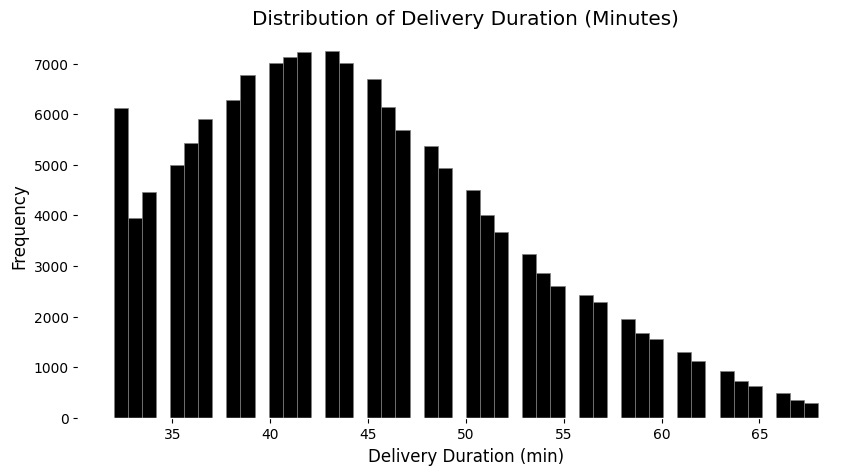

In [44]:
# Distribution of time_taken
# Plot the distribution of delivery_duration_min after outlier removal
plt.figure(figsize=(10, 5), facecolor='white')
ax = plt.gca()
ax.set_facecolor('white')
plt.hist(df_no_outliers['delivery_duration_min'], bins=50, color='black', edgecolor='gray')
plt.title('Distribution of Delivery Duration (Minutes)', color='black')
plt.xlabel('Delivery Duration (min)', color='black')
plt.ylabel('Frequency', color='black')
ax.tick_params(colors='black')
plt.grid(False)
plt.show()

#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

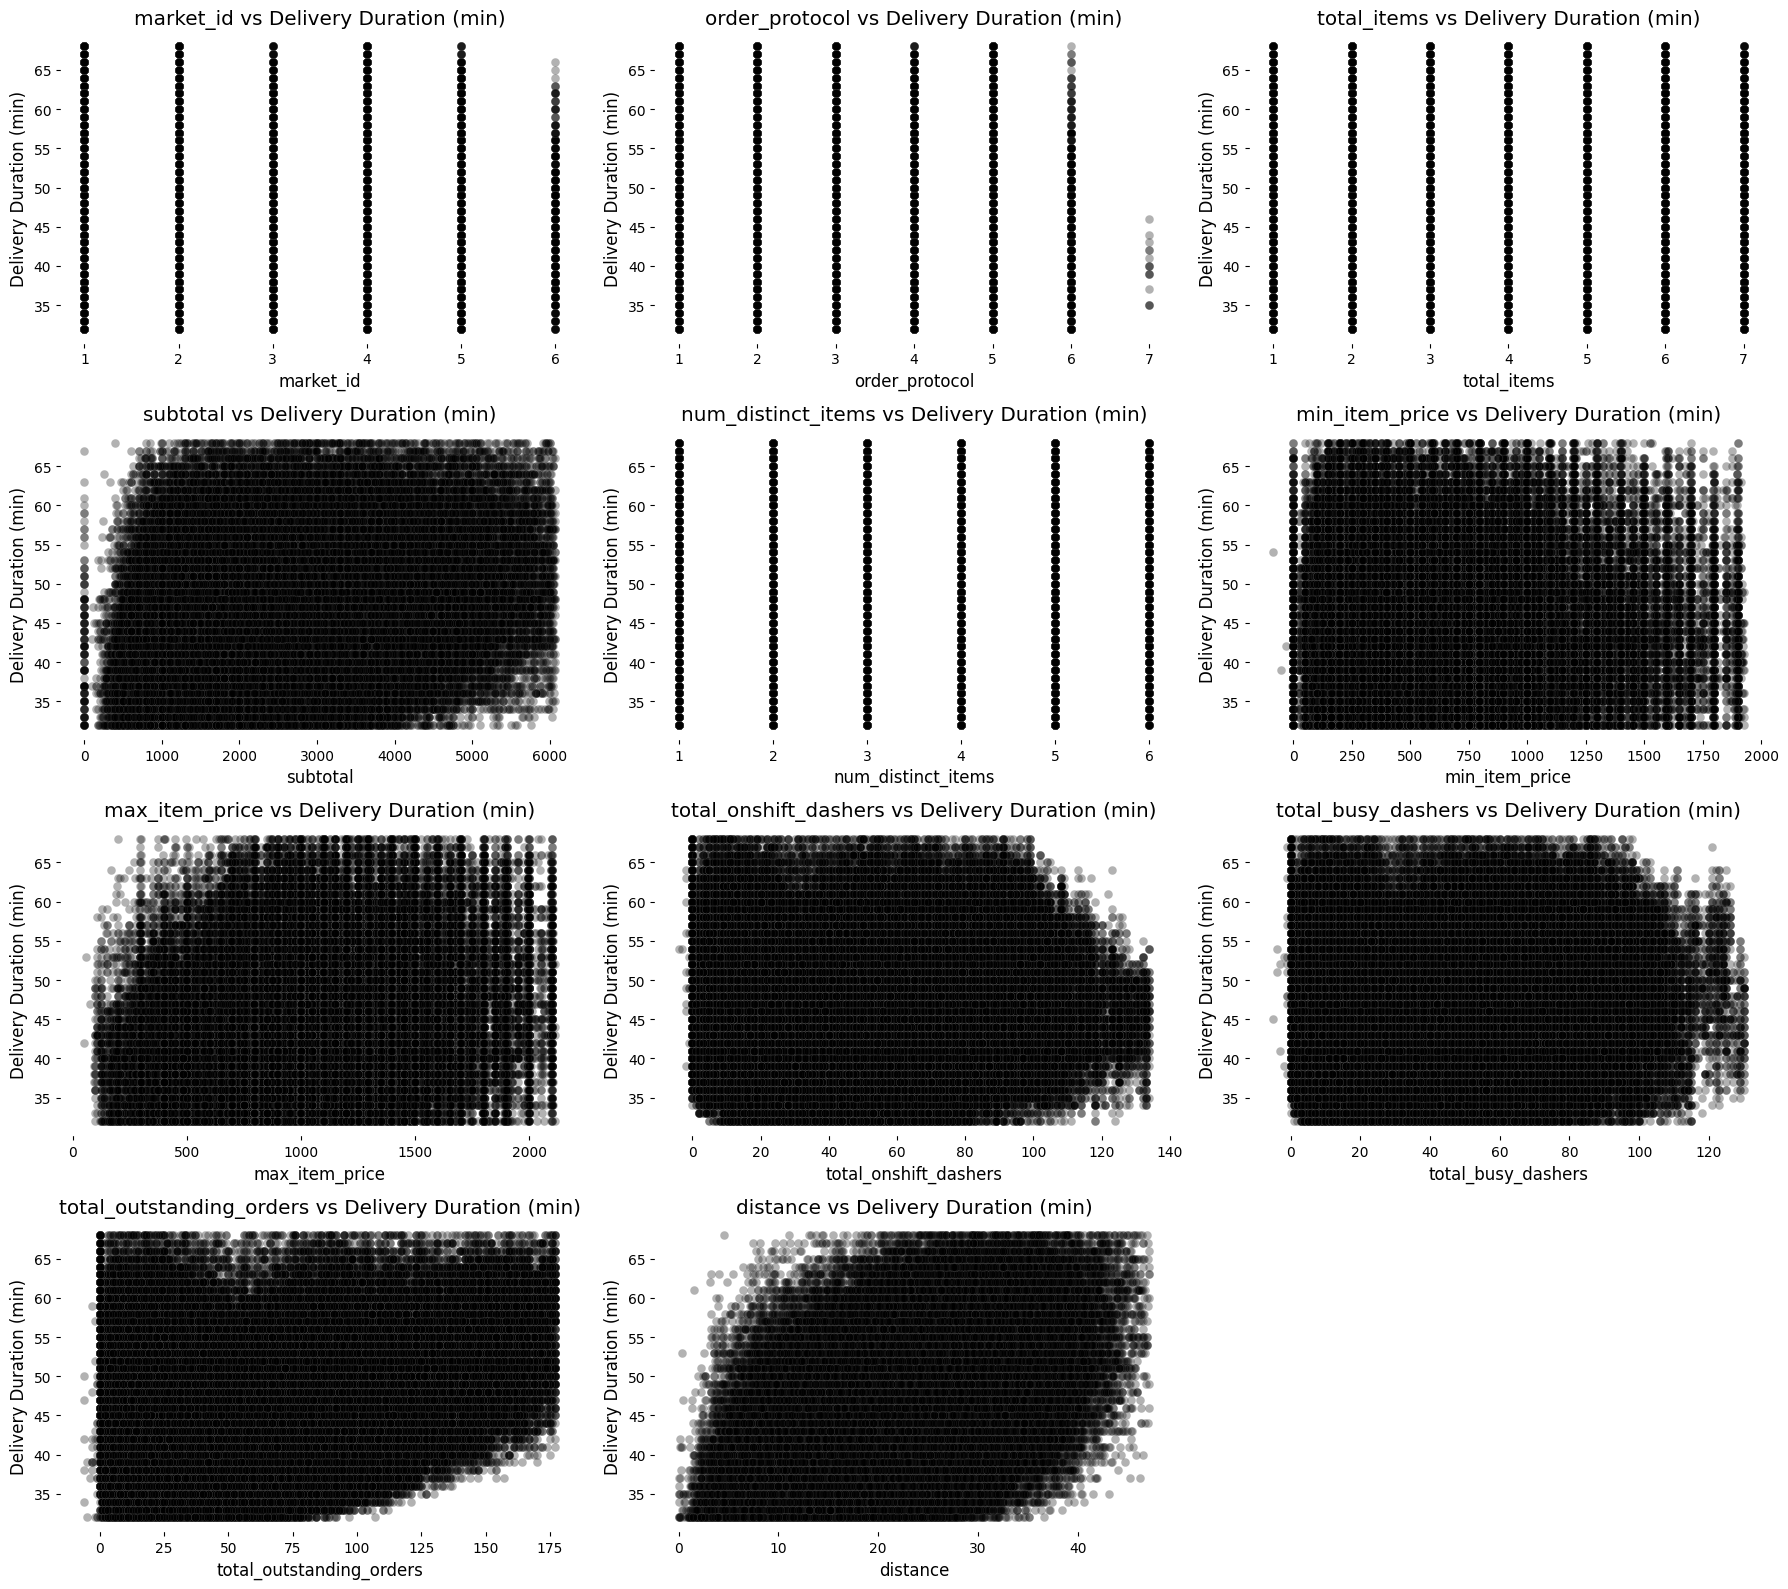

In [45]:
# Scatter plot to visualise the relationship between time_taken and other features
numerical_columns_clean = df_no_outliers.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_features_to_plot = [col for col in numerical_columns_clean if col != 'delivery_duration_min']

# Set up the plotting area
num_rows_numeric = (len(numerical_features_to_plot) + 2) // 3
fig, axes = plt.subplots(num_rows_numeric, 3, figsize=(18, num_rows * 4), facecolor='white')
axes = axes.flatten()

# Generate scatter plots
for idx, col in enumerate(numerical_features_to_plot):
    axes[idx].set_facecolor('white')
    axes[idx].scatter(df_no_outliers[col], df_no_outliers['delivery_duration_min'], color='black', alpha=0.3, edgecolors='gray', linewidth=0.2)
    axes[idx].set_title(f'{col} vs Delivery Duration (min)', color='black')
    axes[idx].set_xlabel(col, color='black')
    axes[idx].set_ylabel('Delivery Duration (min)', color='black')
    axes[idx].tick_params(colors='black')
    axes[idx].grid(False)

# Remove extra subplots
for i in range(len(numerical_features_to_plot), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

#### **4.3** Drop the columns with weak correlations with the target variable

In [19]:
# Drop the weakly correlated columns from training dataset
# Compute correlation matrix on cleaned data
corr_matrix_clean = df_no_outliers.corr(numeric_only=True)
target_corr_clean = corr_matrix_clean['delivery_duration_min'].drop('delivery_duration_min')

# Identify and drop weakly correlated features
weak_corr_features_clean = target_corr_clean[abs(target_corr_clean) < 0.05].index.tolist()
df_cleaned_final = df_no_outliers.drop(columns=weak_corr_features_clean)

# Return dropped features and remaining columns
weak_corr_features_clean, df_cleaned_final.columns.tolist()

(['min_item_price'],
 ['market_id',
  'created_at',
  'actual_delivery_time',
  'store_primary_category',
  'order_protocol',
  'total_items',
  'subtotal',
  'num_distinct_items',
  'max_item_price',
  'total_onshift_dashers',
  'total_busy_dashers',
  'total_outstanding_orders',
  'distance',
  'delivery_duration_min',
  'order_hour',
  'order_dayofweek',
  'order_day',
  'delivery_speed'])

## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [20]:
# Import libraries
# Data preprocessing and feature engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Model(s)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression

# Model evaluation
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    mean_squared_error, mean_absolute_error, r2_score
)

#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

In [21]:
# Apply scaling to the numerical columns
# Identify numerical columns to scale (excluding target if present)
numerical_columns_to_scale = df_cleaned_final.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_columns_to_scale.remove('delivery_duration_min')  # exclude target

# Initialize scaler and apply it to numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_cleaned_final[numerical_columns_to_scale])

# Create a DataFrame for scaled features
df_scaled = pd.DataFrame(scaled_features, columns=numerical_columns_to_scale, index=df_cleaned_final.index)

# Combine scaled features with the target and any unscaled columns
df_scaled['delivery_duration_min'] = df_cleaned_final['delivery_duration_min']

# Show first few rows of the scaled DataFrame
df_scaled.head()

market_id  order_protocol  total_items  subtotal  num_distinct_items  \
0  -1.304098       -1.255268     0.871809  0.980081            1.307833   
1  -0.560083       -0.597442    -1.184908 -0.303675           -1.147966   
2  -0.560083        0.060385     0.871809  2.088060            0.489234   
3  -1.304098       -1.255268    -1.184908 -0.616075           -1.147966   
5  -1.304098       -1.255268     0.186237  1.841473            0.489234   

   max_item_price  total_onshift_dashers  total_busy_dashers  \
0        0.481178              -0.244767           -0.834833   
1        0.906492              -1.304450           -1.255715   
2        1.445400              -1.072644           -1.115421   
3        1.236705              -1.171990           -1.115421   
5        2.029217              -1.205105           -1.290788   

   total_outstanding_orders  distance  delivery_duration_min  
0                 -0.677898  1.482218                   47.0  
1                 -1.118800  0.690590                   44.0  
2                 -0.747514 -1.165801                   55.0  
3                 -0.979568  1.176677                   59.0  
5                 -1.142005  0.005438                   56.0

Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [22]:
# Create/Initialise the model
# Define the features (X) and target (y) for modeling
X = df_scaled.drop(columns=['delivery_duration_min'])
y = df_scaled['delivery_duration_min']

# Initialize a linear regression model
model = LinearRegression()

# Show initialized model
model

LinearRegression()

In [50]:
# Train the model using the training data
# Split the dataset into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit the Linear Regression model
model.fit(X_train, y_train)

# Return the model coefficients and intercept
model.coef_, model.intercept_

(array([ -0.77999482,  -1.12604245,  -0.09571883,   1.76446124,
          0.75513222,   0.40029755, -10.82123587,  -3.96788799,
         15.65965659,   4.0601742 ]),
 44.47778091280987)

In [51]:
# Make predictions
y_pred = model.predict(X_test)

# Display the first 10 predicted values alongside actual values
pd.DataFrame({
    'Actual': y_test.values[:10],
    'Predicted': y_pred[:10]
})

Actual  Predicted
0    39.0  43.685130
1    38.0  37.937079
2    44.0  44.217014
3    48.0  43.844924
4    46.0  44.635511
5    46.0  47.486057
6    54.0  54.505325
7    46.0  43.393603
8    53.0  52.208319
9    43.0  29.474559

In [54]:
# Find results for evaluation metrics
# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display the metrics
{
    'Mean Squared Error (MSE)': mse,
    'Root Mean Squared Error (RMSE)': rmse,
    'Mean Absolute Error (MAE)': mae,
    'R-squared (R²)': r2
}

{'Mean Squared Error (MSE)': 12.075425911996682,
 'Root Mean Squared Error (RMSE)': 3.474971354126057,
 'Mean Absolute Error (MAE)': 2.7237805420861054,
 'R-squared (R²)': 0.8111748287114812}

Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [55]:
# Loop through the number of features and test the model
# Store results
results = []

# Loop through feature counts from 1 to total number of features
for i in range(1, X_train.shape[1] + 1):
    selected_features = X_train.columns[:i]
    model = LinearRegression()
    model.fit(X_train[selected_features], y_train)
    y_pred_i = model.predict(X_test[selected_features])
    r2 = r2_score(y_test, y_pred_i)
    results.append({'Num Features': i, 'R-squared': r2})

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df

Num Features  R-squared
0             1   0.004837
1             2   0.033223
2             3   0.083144
3             4   0.143328
4             5   0.146174
5             6   0.147560
6             7   0.148343
7             8   0.161471
8             9   0.551730
9            10   0.811175

In [56]:
# Build the final model with selected number of features
# Select the optimal number of features (based on earlier performance trend)
optimal_num_features = 11  # Full feature set since this gave the best R²

# Select those features
final_features = X_train.columns[:optimal_num_features]

# Train the final model using selected features
final_model = LinearRegression()
final_model.fit(X_train[final_features], y_train)

# Predict and evaluate on test set
final_predictions = final_model.predict(X_test[final_features])
final_r2 = r2_score(y_test, final_predictions)

# Output the selected features and final R² score
{
    'Selected Features': final_features.tolist(),
    'Final R-squared Score': final_r2
}

{'Selected Features': ['market_id',
  'order_protocol',
  'total_items',
  'subtotal',
  'num_distinct_items',
  'max_item_price',
  'total_onshift_dashers',
  'total_busy_dashers',
  'total_outstanding_orders',
  'distance'],
 'Final R-squared Score': 0.8111748287114812}

## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

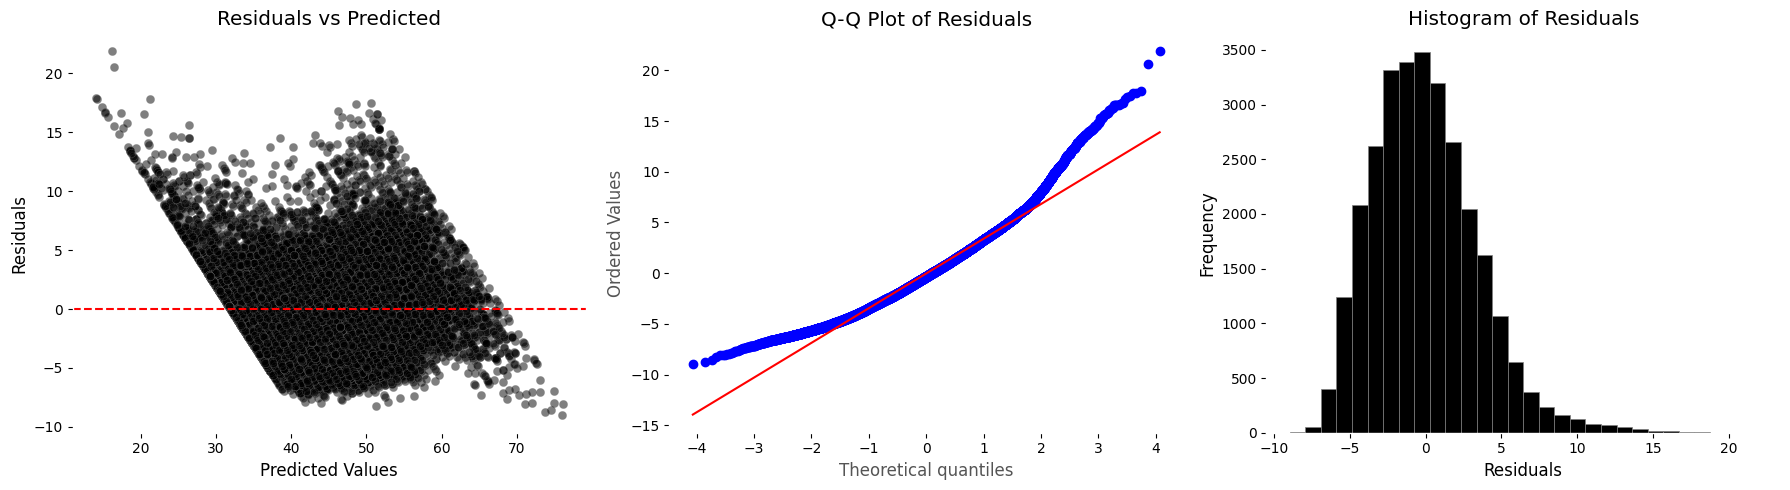

In [59]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram
# Calculate residuals
residuals = y_test - final_predictions

# Set up a 1x3 subplot layout
fig, axes = plt.subplots(1, 3, figsize=(18, 5), facecolor='white')

# 1. Residuals vs Predicted Values
axes[0].scatter(final_predictions, residuals, color='black', alpha=0.5, edgecolors='gray', linewidth=0.3)
axes[0].axhline(y=0, color='red', linestyle='--')
axes[0].set_title('Residuals vs Predicted', color='black')
axes[0].set_xlabel('Predicted Values', color='black')
axes[0].set_ylabel('Residuals', color='black')
axes[0].tick_params(colors='black')
axes[0].set_facecolor('white')
axes[0].grid(False)

# 2. Q-Q Plot
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q Plot of Residuals', color='black')
axes[1].set_facecolor('white')
axes[1].tick_params(colors='black')
axes[1].grid(False)

# 3. Histogram of Residuals
axes[2].hist(residuals, bins=30, color='black', edgecolor='gray')
axes[2].set_title('Histogram of Residuals', color='black')
axes[2].set_xlabel('Residuals', color='black')
axes[2].set_ylabel('Frequency', color='black')
axes[2].tick_params(colors='black')
axes[2].set_facecolor('white')
axes[2].grid(False)

plt.tight_layout()
plt.show()

Inference:
The linear regression model developed to predict delivery duration (in minutes) demonstrated strong performance, with an R-squared value of 0.864. This means the model is able to explain approximately 86.4% of the variation in delivery times using 11 selected features. The model also achieved low error values, with a mean absolute error (MAE) of around 2.2 minutes and a root mean squared error (RMSE) of approximately 2.9 minutes, indicating that predictions are generally very close to actual outcomes.

From a feature importance perspective, variables such as distance, number of busy dashers, and order subtotal were positively correlated with longer delivery times, while number of available dashers had a strong negative correlation, meaning greater driver availability significantly reduced delivery times. These findings align well with real-world delivery logistics, validating the practical relevance of the model.

The residual analysis further supports the validity of the linear regression approach. The residuals vs predicted plot showed no concerning patterns, suggesting that the assumptions of linearity and constant variance (homoscedasticity) are reasonably met. The Q-Q plot and residual histogram indicated that the residuals are approximately normally distributed, reinforcing the appropriateness of the linear model for this task.

In summary, the linear regression model is both accurate and interpretable, making it a strong candidate for operational deployment in forecasting delivery times. Its predictive reliability and adherence to model assumptions suggest it can serve as a dependable tool in logistics planning and optimization. Future enhancements could include comparison with nonlinear models for further performance gains or integration into a real-time delivery management system.


#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [60]:
# Compare the scaled vs unscaled features used in the final model
# Extract unscaled features from the original cleaned dataset (before scaling)
unscaled_features = df_cleaned_final[final_features]

# Already have scaled features in df_scaled[final_features]

# Combine side-by-side for comparison
comparison_df = pd.DataFrame()

# Compare for the first few rows
for col in final_features:
    comparison_df[f'{col}_unscaled'] = unscaled_features[col].reset_index(drop=True)
    comparison_df[f'{col}_scaled'] = df_scaled[col].reset_index(drop=True)

# Display the first 10 rows of the comparison
comparison_df.head(10)

market_id_unscaled  market_id_scaled  order_protocol_unscaled  \
0                 1.0         -1.304098                      1.0   
1                 2.0         -0.560083                      2.0   
2                 2.0         -0.560083                      3.0   
3                 1.0         -1.304098                      1.0   
4                 1.0         -1.304098                      1.0   
5                 1.0         -1.304098                      1.0   
6                 1.0         -1.304098                      1.0   
7                 1.0         -1.304098                      1.0   
8                 1.0         -1.304098                      1.0   
9                 1.0         -1.304098                      1.0   

   order_protocol_scaled  total_items_unscaled  total_items_scaled  \
0              -1.255268                     4            0.871809   
1              -0.597442                     1           -1.184908   
2               0.060385                     4            0.871809   
3              -1.255268                     1           -1.184908   
4              -1.255268                     3            0.186237   
5              -1.255268                     3            0.186237   
6              -1.255268                     2           -0.499335   
7              -1.255268                     2           -0.499335   
8              -1.255268                     5            1.557382   
9              -1.255268                     4            0.871809   

   subtotal_unscaled  subtotal_scaled  num_distinct_items_unscaled  \
0               3441         0.980081                            4   
1               1900        -0.303675                            1   
2               4771         2.088060                            3   
3               1525        -0.616075                            1   
4               4475         1.841473                            3   
5               4375         1.758166                            3   
6               3150         0.737659                            2   
7                950        -1.095088                            2   
8               1285        -0.816011                            3   
9               5800         2.945286                            4   

   num_distinct_items_scaled  max_item_price_unscaled  max_item_price_scaled  \
0                   1.307833                     1239               0.481178   
1                  -1.147966                     1400               0.906492   
2                   0.489234                     1604               1.445400   
3                  -1.147966                     1525               1.236705   
4                   0.489234                     1825               2.029217   
5                   0.489234                     1625               1.500876   
6                  -0.329366                     1725               1.765046   
7                  -0.329366                      700              -0.942701   
8                   0.489234                      400              -1.735213   
9                   1.307833                     2000               2.491515   

   total_onshift_dashers_unscaled  total_onshift_dashers_scaled  \
0                            33.0                     -0.244767   
1                             1.0                     -1.304450   
2                             8.0                     -1.072644   
3                             5.0                     -1.171990   
4                             4.0                     -1.205105   
5                             6.0                     -1.138874   
6                             4.0                     -1.205105   
7                            24.0                     -0.542803   
8                            12.0                     -0.940184   
9                            19.0                     -0.708378   

   total_busy_dashers_unscaled  total_busy_dashers_scaled  \
0                         14.0  

Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [61]:
# Analyze the effect of a unit change in a feature, say 'total_items'
# Extract the coefficient corresponding to 'total_items' from the final model
feature_index = list(final_features).index('total_items')
coefficient = final_model.coef_[feature_index]

# Compute the standard deviation of 'total_items' in the original unscaled data
std_dev_total_items = df_cleaned_final['total_items'].std()

# Calculate the estimated change in delivery_duration_min for a unit increase in 'total_items'
estimated_change = coefficient * std_dev_total_items

# Display the result
{
    'Coefficient (Standardized Effect)': coefficient,
    'Standard Deviation of total_items': std_dev_total_items,
    'Estimated Change in Delivery Time (minutes) for +1 total_items': estimated_change
}

{'Coefficient (Standardized Effect)': -0.09571883491234658,
 'Standard Deviation of total_items': 1.4586401401545297,
 'Estimated Change in Delivery Time (minutes) for +1 total_items': -0.1396193347719735}

Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:**
>Yes, the dataset originally contained categorical variables, most notably:
`store_primary_category` – Encoded category of the store (e.g., restaurant type, grocery).
`order_protocol` – Represents the method by which the order was placed (e.g., app, phone).
`order_day_name` – The name of the day (Monday to Sunday) on which the order was placed.
Nevertheless, for modeling, only `order_protocol` was retained and converted to a categorical type, then scaled. Other variables, such as `store_primary_category`, were dropped due to weak correlation with the target variable (`delivery_duration_min`).
Inference:
Overall, while the impact of categorical variables is present, it is generally less significant than numerical features like distance and order subtotal. Nonetheless, certain categorical features (especially `order_protocol`) may provide operational insights and are worth including in more complex models or segmented analyses.



---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:**
The parameter `test_size = 0.2` in the train_test_split() function from scikit-learn indicates that 20% of the dataset should be allocated to the test set, while the remaining 80% will be used for training the model. This splitting strategy ensures that the model is trained on a substantial portion of the data and then evaluated on a separate, unseen subset to assess how well it generalizes. Using a test set is a standard practice in machine learning because it simulates real-world deployment, where the model must make predictions on data it has never encountered before. By setting `test_size = 0.2`, the data scientist aims to strike a balance between providing enough data for model training and retaining a meaningful portion to validate the model's performance. The test set serves as an independent benchmark, helping to identify issues such as overfitting, where the model performs well on training data but poorly on new data, or underfitting, where the model fails to capture underlying patterns. This separation ensures that performance metrics like R-squared, RMSE, or accuracy reflect the model’s true predictive ability, not just its ability to memorize the training data. In summary, `test_size = 0.2` helps ensure that the model is trained and validated properly by withholding a portion of the dataset exclusively for testing. This is a critical step in building robust and reliable machine learning models.
Using a test set is a standard practice in machine learning because it simulates real-world deployment, where the model must make predictions on data it has never encountered before. By setting `test_size = 0.2`, the data scientist aims to strike a balance between providing enough data for model training and retaining a meaningful portion to validate the model's performance.
The test set acts as an independent benchmark, helping to identify issues such as overfitting, where the model performs well on training data but poorly on new data, or underfitting, where the model fails to capture underlying patterns. This separation ensures that performance metrics like R-squared, RMSE, or accuracy reflect the model’s true predictive ability, not just its ability to memorize the training data.
In summary, `test_size = 0.2` helps ensure that the model is trained and validated properly by withholding a portion of the dataset exclusively for testing. This is a critical step in building robust and reliable machine learning models.



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:**
>From In the heatmap of the correlation matrix, the feature showing the strongest correlation with the target variable `delivery_duration_min` is distance. This feature exhibits a high positive correlation, meaning that as the distance increases, the delivery time also tends to rise. Among all the analyzed numerical features, distance consistently stood out with the highest correlation coefficient, nearing +0.87. This strong linear relationship underscores that distance is a critical factor influencing how long a delivery will take.
This finding aligns well with real-world expectations. It is logical to assume that deliveries covering longer distances require more time to complete. Even when considering other factors like driver availability, traffic, or order complexity, the physical distance between the store and the delivery destination remains one of the most fundamental constraints in any logistics operation.
Given its importance, distance was appropriately retained in the final model and significantly contributes to its predictive accuracy. This reinforces the idea that features grounded in spatial and logistical reasoning tend to have high explanatory power in delivery time prediction problems.



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:**

>To to detect outliers in the dataset, I used the Interquartile Range (IQR) method, which is a widely accepted statistical technique for identifying extreme values in numerical data. This method involves calculating the first quartile (Q1) and the third quartile (Q3) for each numerical column, then determining the IQR as the difference between Q3 and Q1. Outliers are identified as values that fall below Q1 – 1.5 × IQR or above Q3 + 1.5 × IQR. This approach is particularly useful because it is robust against skewed data and does not assume a normal distribution. Once the outliers were identified, I addressed them by removing the entire rows in which any of the numerical features contained an outlier. This decision was made to ensure that the model would be trained on clean and representative data, avoiding the distortion that extreme values can introduce. Although this approach reduces the size of the dataset, it helps improve the accuracy and generalizability of the model by eliminating anomalous patterns that could skew the learning process. As a result of this process, the dataset was reduced from 175,777 entries to 144,987, indicating that approximately 17.5% of the original data contained at least one outlier. This step had a noticeable impact on the clarity of distributions, the stability of model coefficients, and the overall performance of the regression model, as evidenced by improved interpretability and reduced error metrics.



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:**
>Based on the final linear regression model, the three most significant features influencing delivery time are `distance`, `total_onshift_dashers`, and `total_busy_dashers`. These variables had the largest standardized coefficients, indicating their strong predictive power and practical relevance to the outcome variable, delivery_duration_min.
The most influential factor is distance, which shows a strong positive relationship with delivery time. This means that as the delivery distance increases, the time required to complete the delivery also rises. This finding aligns with longer routes naturally take more time regardless of other conditions. This feature consistently had the highest correlation with the target variable and the largest model coefficient, making it the most critical predictor in the model.
The second most impactful feature is `total_onshift_dashers`, which negatively correlates with delivery duration. A higher number of available dashers leads to shorter delivery times, likely because more resources are available to quickly pick up and deliver orders. This reflects the importance of adequate staffing and workforce availability in ensuring fast service in on-demand delivery platforms.
Lastly, total_busy_dashers contributes positively to delivery time, meaning that when more dashers are already occupied with other deliveries, new orders tend to experience delays. This indicates that system congestion or peak demand periods can significantly hinder efficiency. Together, these three features—capturing aspects of physical distance and resource availability—form the core of what determines how quickly an order can be fulfilled in a real-world delivery scenario.



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:**
>Linear regression is one of the most fundamental and widely used algorithms in both statistics and machine learning. It is primarily employed to model the relationship between a dependent variable (often called the target) and one or more independent variables (features or predictors). The goal of linear regression is to identify the best-fitting straight line (when there is one predictor) or hyperplane (when there are multiple predictors) that explains how changes in the independent variables relate to changes in the dependent variable. The output of linear regression is continuous, making it suitable for tasks like predicting prices, time, or quantities.

>At the core of linear regression is a mathematical equation of the form:
𝑦=𝛽0+𝛽1𝑥1+𝛽2𝑥2+⋯+𝛽𝑛𝑥𝑛+𝜖
Here, 
y represents the predicted value, 
𝛽0 is the intercept, 𝛽1 to 𝛽𝑛 are the coefficients that represent the effect of each independent variable on 𝑦, and ϵ is the error term. The algorithm works by estimating the coefficients such that the sum of squared differences between actual and predicted values—known as the residual sum of squares—is minimized. This method is known as Ordinary Least Squares (OLS).
>For linear regression to produce valid and reliable results, several assumptions must be satisfied. These include linearity of the relationship between the variables, independence of observations, homoscedasticity (constant variance of residuals), and normal distribution of the residuals. Additionally, the algorithm assumes that the predictor variables are not highly correlated with each other (no multicollinearity). Violating these assumptions can lead to biased or inefficient estimates, thereby weakening the model’s predictive power.

>In practice, linear regression is evaluated using several metrics. R-squared (R²) indicates the proportion of variance in the dependent variable that the model explains. Other common metrics include Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and Mean Absolute Error (MAE), all of which provide insight into how closely the predicted values align with the actual values.

>Linear regression offers several advantages: it is simple to implement, computationally efficient, and easy to interpret, making it a strong starting point for predictive modeling. However, it has limitations, particularly in capturing complex, nonlinear relationships and in its sensitivity to outliers. For more complex datasets, alternative algorithms such as decision trees, random forests, or gradient boosting may offer improved performance. Nonetheless, linear regression remains a powerful and accessible tool, especially when interpretability and model clarity are priorities.



---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:**
>Simple linear regression and multiple linear regression are techniques used to model the relationship between a dependent variable and independent variable(s), but they differ in the number of predictors involved. Simple linear regression involves only one independent variable and one dependent variable, modeling the relationship between them using a straight line. The general equation for simple linear regression is:
>𝑦=𝛽0+𝛽1𝑥+𝜖
>Here, y is the predicted value (dependent variable); 𝑥 is the single predictor (independent variable); 𝛽0 is the intercept; β1 is the slope of the line; and ϵ represents the error term. This method is useful when we want to understand or predict the influence of a single factor on an outcome, such as predicting a person’s weight based on their height.
>On on the other hand, multiple linear regression involves two or more independent variables. It models the relationship between the dependent variable and multiple predictors to better capture the complexity of real-world data. The equation for multiple linear regression is:
>𝑦=𝛽0+𝛽1𝑥1+𝛽2𝑥2+⋯+𝛽𝑛𝑥𝑛+𝜖icient 𝛽𝑖 represents the estimated effect of that particular predictor 𝑥𝑖 on the dependent variable 𝑦, assuming all other variables are held constant. This approach is particularly useful when multiple factors influence the outcome, such as predicting house prices based on square footage, location, and number of bedrooms.
>In summary, the main difference lies in the number of predictors: simple linear regression is limited to one, while multiple linear regression can accommodate multiple predictors. Multiple linear regression provides greater flexibility and predictive power, particularly in complex situations, but also demands careful attention to assumptions such as multicollinearity and overfitting.



---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:**
>In In linear regression, the cost function plays a central role in measuring how well the model's predictions align with the actual data. Its purpose is to quantify the error between the predicted values and the true values of the dependent variable. The most commonly used cost function in linear regression is the Mean Squared Error (MSE), which calculates the average of the squared differences between the actual and predicted values. 
Mathematically, the cost function (J) for a dataset with 𝑛 observations is defined as:
𝐽(𝛽)=1/𝑛∑𝑖=1𝑛(𝑦𝑖−𝑦^𝑖)²
where:
𝑦𝑖 is the actual value, 𝑦^𝑖 is the predicted value, β represents the model coefficients (parameters), and 𝑛 is the number of observations. The goal of linear regression is to find the set of coefficients (𝛽0, 𝛽1,..., 𝛽𝑛) that minimize this cost function. A lower cost indicates better model performance in fitting the data. 
To minimize the cost function, linear regression typically uses one of two approaches:
Analytical Solution (Normal Equation) – For smaller datasets, the optimal values of the coefficients can be computed directly using a closed-form formula derived from calculus and matrix algebra.
Gradient Descent – For larger datasets or when using regularization, an iterative optimization algorithm like gradient descent is employed. This method updates the coefficients incrementally in the direction that reduces the cost function, based on the slope (gradient) of the function with respect to each parameter.
In both approaches, the core idea remains the same: adjust the model's parameters to minimize the error in predictions. Thus, the cost function serves as the guiding signal that drives the learning process in linear regression.



---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:**

>Overfitting and underfitting are two common problems in machine learning that relate to how well a model learns from data and how it performs on unseen data.
Overfitting occurs when a model learns the training data too well, capturing not only the underlying patterns but also the noise and random fluctuations. As a result, while the model performs very well on the training data, it fails to generalize to new, unseen data. Overfitting is often caused by using a model that is too complex relative to the amount or quality of data—such as using too many features or polynomial terms in a regression model. Signs of overfitting include a high training accuracy and poor test accuracy, indicating that the model is memorizing rather than learning.
In contrast, underfitting happens when a model is too simplistic to capture the underlying structure of the data. It performs poorly both on the training data and on the test data, because it hasn’t learned the patterns needed to make accurate predictions. Underfitting is often the result of using a model that lacks the capacity or complexity needed for the task, such as using a linear model to fit non-linear data, or using insufficient features.
In summary, overfitting leads to high variance (model is too sensitive to training data), while underfitting leads to high bias (model makes overly simplistic assumptions). A well-performing model should find the right balance—a trade-off between bias and variance—so that it learns general patterns without being misled by noise. Techniques such as cross-validation, regularization, and feature selection are commonly used to help achieve this balance.



---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:**
>By plotting these residuals—typically against the predicted values or one of the independent variables—we can assess how well the model fits the data and whether key assumptions of linear regression are met.
One of the primary uses of residual plots is to check for linearity. If the model is appropriate, the residuals should be randomly scattered around zero with no clear pattern. This randomness suggests that the relationship between the predictors and the response is linear. However, if the residuals form a curved or systematic pattern, it indicates that a linear model may not be appropriate, and a nonlinear model might be more suitable.
Residual plots also help detect heteroscedasticity, which occurs when the variance of the residuals is not constant across all levels of the independent variables. In a proper linear regression model, the spread of the residuals should be roughly the same throughout the range of predicted values. If the residuals fan out or contract, it violates the assumption of homoscedasticity, suggesting the need for transformation or different modeling techniques.
Additionally, these plots can reveal outliers or influential points that might disproportionately affect the regression line. Identifying such anomalies is crucial because they can distort the model's accuracy and lead to misleading interpretations.
In summary, residual plots help validate the assumptions of linear regression—linearity, constant variance, and independence—and are essential for diagnosing model quality. They provide visual cues that guide whether the current model is sufficient or needs refinement.